# Libraries and Dependencies

In [ ]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
from textblob import TextBlob
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords

from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

import nlpaug.augmenter.word as naw
import random

# EDA

In [41]:
#readcsv file
df = pd.read_csv(r'sentiment_test_cases.csv')
df

,expected_sentiment,text
0,positive,@stellargirl I loooooooovvvvvveee my Kindle2. ...
1,positive,Reading my kindle2... Love it... Lee childs i...
2,positive,"Ok, first assesment of the #kindle2 ...it fuck..."
3,positive,@kenburbary You'll love your Kindle2. I've had...
4,positive,@mikefish Fair enough. But i have the Kindle2...
...,...,...
493,neutral,Ask Programming: LaTeX or InDesign?: submitted...
494,negative,"On that note, I hate Word. I hate Pages. I hat..."
495,positive,Ahhh... back in a *real* text editing environm...
496,negative,"Trouble in Iran, I see. Hmm. Iran. Iran so far..."


In [42]:
#preprocess text
import nltk
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
def data_processing(text):
    text = text.lower()
    text = re.sub(r'https\S+|www\S+https\S+','',text, flags=re.MULTILINE)
    text = re.sub(r'\@w+|\#','',text)
    text = re.sub(r'[^\w\s]','',text)
    text_tokens = word_tokenize(text)
    filtered_text = [w for w in text_tokens if not w in stop_words]
    return  ' '.join(filtered_text)

df.text = df['text'].apply(data_processing)

df = df.drop_duplicates('text')
df

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\blas_\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\blas_\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,expected_sentiment,text
0,positive,stellargirl loooooooovvvvvveee kindle2 dx cool...
1,positive,reading kindle2 love lee childs good read
2,positive,ok first assesment kindle2 fucking rocks
3,positive,kenburbary youll love kindle2 ive mine months ...
4,positive,mikefish fair enough kindle2 think perfect
...,...,...
493,neutral,ask programming latex indesign submitted calci...
494,negative,note hate word hate pages hate latex said hate...
495,positive,ahhh back real text editing environment lt3 latex
496,negative,trouble iran see hmm iran iran far away flocko...


In [43]:
#data augmentation
def augment_text(text):
    # Initialize the Word augmenter (you can choose different augmentation techniques)
    aug = naw.SynonymAug(aug_src='wordnet')
    # Apply augmentation to generate a new text
    augmented_text = aug.augment(text)
    augmented_text = str(augmented_text)
    return augmented_text

augmented_df = df.copy()
num_augmentations = 3
augmented_data = []

# Iterate through the original DataFrame
for _, row in df.iterrows():
    original_text = row['text']
    sentiment = row['expected_sentiment']

    # Augment the text and preserve the sentiment label
    for _ in range(num_augmentations):
        augmented_text = augment_text(original_text)
        augmented_data.append({'expected_sentiment': sentiment, 'text': augmented_text})

# Append the augmented data to the DataFrame
augmented_df = augmented_df.append(augmented_data, ignore_index=True)
df = pd.concat([df, augmented_df], ignore_index=True)
df

,expected_sentiment,text
0,positive,stellargirl loooooooovvvvvveee kindle2 dx cool...
1,positive,reading kindle2 love lee childs good read
2,positive,ok first assesment kindle2 fucking rocks
3,positive,kenburbary youll love kindle2 ive mine months ...
4,positive,mikefish fair enough kindle2 think perfect
...,...,...
2485,negative,['hassle iran see hmm persia persia far away f...
2486,negative,['trouble iran see hmm persia persia far aside...
2487,negative,['read tweets get along iran whole matter terr...
2488,negative,['read tweet get iran whole thing terrifying i...


In [44]:
#Stemming and Lemmatization
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    words = text.split()
    stemmed_words = [stemmer.stem(word) for word in words]
    lemmatized_words = [lemmatizer.lemmatize(word) for word in stemmed_words]
    
    return ' '.join(lemmatized_words)

df['text'] = df['text'].apply(preprocess_text)

df

,expected_sentiment,text
0,positive,stellargirl loooooooovvvvvvee kindle2 dx cool ...
1,positive,read kindle2 love lee child good read
2,positive,ok first ass kindle2 fuck rock
3,positive,kenburbari youll love kindle2 ive mine month n...
4,positive,mikefish fair enough kindle2 think perfect
...,...,...
2485,negative,['hassl iran see hmm persia persia far away fl...
2486,negative,['troubl iran see hmm persia persia far asid f...
2487,negative,['read tweet get along iran whole matter terri...
2488,negative,['read tweet get iran whole thing terrifi incr...


In [45]:
#determine polarity
def polarity(text):
    return TextBlob(text).sentiment.polarity
df['polarity'] = df['text'].apply(polarity)
df


,expected_sentiment,text,polarity
0,positive,stellargirl loooooooovvvvvvee kindle2 dx cool ...,0.317857
1,positive,read kindle2 love lee child good read,0.600000
2,positive,ok first ass kindle2 fuck rock,0.116667
3,positive,kenburbari youll love kindle2 ive mine month n...,0.207273
4,positive,mikefish fair enough kindle2 think perfect,0.566667
...,...,...,...
2485,negative,['hassl iran see hmm persia persia far away fl...,0.100000
2486,negative,['troubl iran see hmm persia persia far asid f...,0.100000
2487,negative,['read tweet get along iran whole matter terri...,-0.150000
2488,negative,['read tweet get iran whole thing terrifi incr...,-0.150000


In [46]:
#classify polarity
def sentiment(label):
    if label <0:
        return 'Negative'
    elif label ==0:
        return 'Neutral'
    elif label >0:
        return 'Positive'

df['sentiment'] = df['polarity'].apply(sentiment)
df

,expected_sentiment,text,polarity,sentiment
0,positive,stellargirl loooooooovvvvvvee kindle2 dx cool ...,0.317857,Positive
1,positive,read kindle2 love lee child good read,0.600000,Positive
2,positive,ok first ass kindle2 fuck rock,0.116667,Positive
3,positive,kenburbari youll love kindle2 ive mine month n...,0.207273,Positive
4,positive,mikefish fair enough kindle2 think perfect,0.566667,Positive
...,...,...,...,...
2485,negative,['hassl iran see hmm persia persia far away fl...,0.100000,Positive
2486,negative,['troubl iran see hmm persia persia far asid f...,0.100000,Positive
2487,negative,['read tweet get along iran whole matter terri...,-0.150000,Negative
2488,negative,['read tweet get iran whole thing terrifi incr...,-0.150000,Negative


     expected_sentiment                                               text  \
259            negative                             kobe best world lebron   
783            positive    best girl hour san francisco mmmmmfamili wonder   
968            positive            kindle2 seem best eread work uk get one   
1750           positive  ['best playoff twelvemonth oh yea lebron melo ...   
1752           positive                         ['khalid0456 lebron best']   
1753           positive                         ['khalid0456 lebron best']   
1754           positive                         ['khalid0456 lebron best']   
1773           negative                         ['kobe best world lebron']   
470            positive            kindle2 seem best eread work uk get one   
285            positive    best girl hour san francisco mmmmmfamili wonder   

      polarity sentiment  
259        1.0  Positive  
783        1.0  Positive  
968        1.0  Positive  
1750       1.0  Positive  
1752  

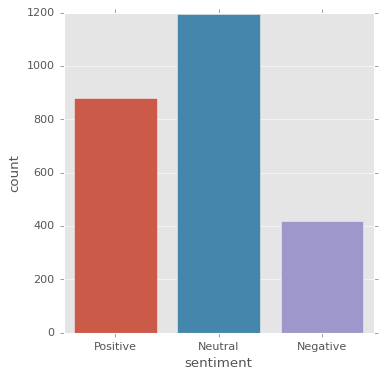

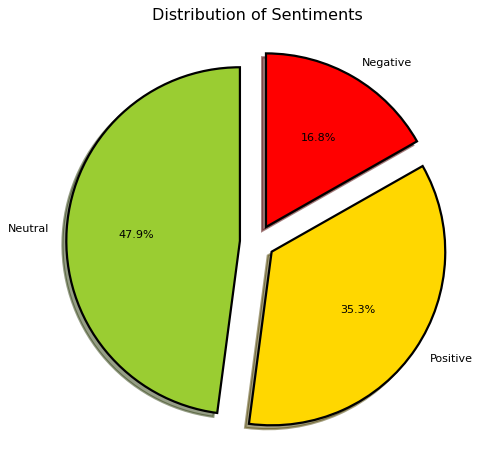

In [47]:
#data analysis
fig = plt.figure(figsize=(5,5))
sns.countplot(x='sentiment',data = df)

fig = plt.figure(figsize=(7,7))
colors = ('yellowgreen', 'gold', 'red')
wp = {'linewidth':2, 'edgecolor':'black'}
tags = df['sentiment'].value_counts()
explode = (0.1,0.1,0.1)
tags.plot(kind='pie', autopct='%1.1f%%', shadow=True, colors = colors,
        startangle=90, wedgeprops = wp, explode = explode, label = '')
plt.title('Distribution of Sentiments')

pos_text = df[df.sentiment == 'Positive']
pos_text = pos_text.sort_values(['polarity'], ascending = False)
print(pos_text.head(10))

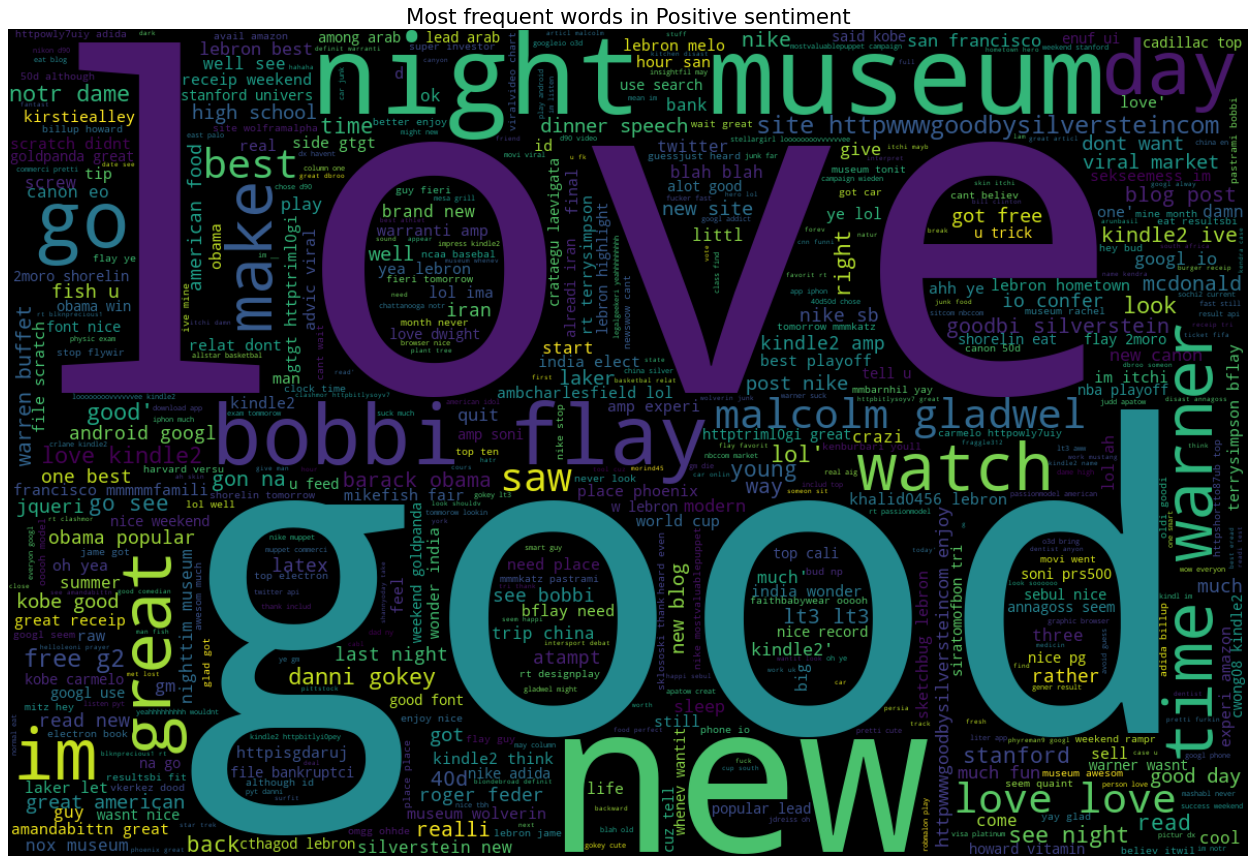

In [48]:
text = ' '.join([word for word in pos_text['text']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1200, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most frequent words in Positive sentiment', fontsize=19)
plt.show()

In [49]:
#check number of features
vect = CountVectorizer(ngram_range=(1,2)).fit(df['text'])
feature_names = vect.get_feature_names_out()
print('Number of features:{}\n'.format(len(feature_names)))
print('First 20 features: {}'.format(feature_names[:20]))

Number of features:10860

First 20 features: ['10' '10 84' '10 bakshish' '10 eighti' '10 line' '10 min' '10 tip' '100'
 '100 twitter' '1000' '1000 freak' '10000' '10000 peopl' '11' '11 next'
 '1200' '1200 pm' '1200 postmortem' '1200 promethium' '13']


In [50]:
#separate train and test data
X = df['text']
Y = df['sentiment']
X = vect.transform(X)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
import warnings
warnings.filterwarnings('ignore')

Test accuracy: 92.77%
[[ 80  10   5]
 [  3 223   6]
 [  4   8 159]]


              precision    recall  f1-score   support

    Negative       0.92      0.84      0.88        95
     Neutral       0.93      0.96      0.94       232
    Positive       0.94      0.93      0.93       171

    accuracy                           0.93       498
   macro avg       0.93      0.91      0.92       498
weighted avg       0.93      0.93      0.93       498



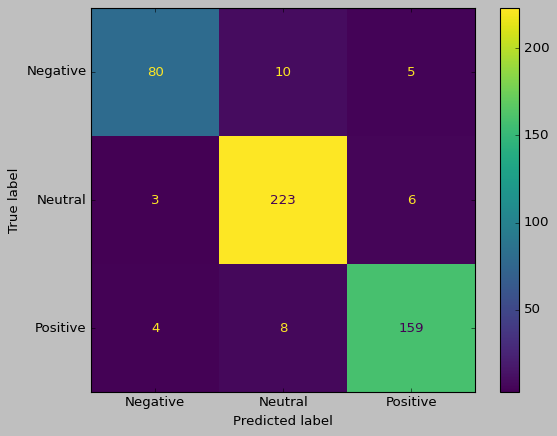

In [52]:
#train the model and diplay the accuracy
logreg = LogisticRegression()
logreg.fit(x_train, y_train)
logreg_pred = logreg.predict(x_test)
logreg_acc = accuracy_score(logreg_pred, y_test)
print('Test accuracy: {:.2f}%'.format(logreg_acc*100))
print(confusion_matrix(y_test, logreg_pred))
print('\n')
print(classification_report(y_test, logreg_pred))
style.use('classic')
cm = confusion_matrix(y_test, logreg_pred, labels=logreg.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=logreg.classes_)
disp.plot()

In [56]:
import joblib

# Save the model to a file
model_filename = 'logistic_regression_sentiment_model.pkl'
joblib.dump(logreg, model_filename)
# Load the model from the file
loaded_model = joblib.load(model_filename)

In [79]:
def analyze_sentiment(user_input, model):
 
    # Use TextBlob for sentiment analysis
    sentiment_blob = TextBlob(user_input)
    polarity = sentiment_blob.sentiment.polarity
    user_input = [user_input]  # Wrap the user input in a list
    user_input = vect.transform(user_input)
    # Predict sentiment using the loaded model
    sentiment = model.predict(user_input)  # Wrap the input in a list and reshape
    sentiment = sentiment.reshape(-1, 1)

    # Calculate the confidence score
    confidence_score = (polarity + 1) / 2 * 100

    return {
        "model_output": sentiment[0][0],  # Get the sentiment from the result
        "confidence_score": round(confidence_score, 2)
    }


In [76]:
user_input = input("Enter a sentence: ")

Enter a sentence: World travel i very good hobby


In [77]:
#preprocess the input text
user_input = data_processing(user_input)
user_input = preprocess_text(user_input)

user_input

'world travel good hobbi'

In [78]:
#process the user input and display the result
result = analyze_sentiment(user_input, loaded_model)

print(f"Input: \"{user_input}\"")
print(f"Output: {result}")

Input: "world travel good hobbi"
Output: {'model_output': 'Positive', 'confidence_score': 85.0}


In [86]:
#process the given test csv file:
#readcsv file
test_df = pd.read_csv(r'test.csv')
test_df
test_df.text = test_df['text'].apply(data_processing)
test_df['text'] = test_df['text'].apply(preprocess_text)

# Apply the analyze_sentiment function to each text in the DataFrame
sentiment_and_confidence = test_df['text'].apply(lambda x: analyze_sentiment(x, loaded_model))

# Assign the resulting Series to DataFrame columns
test_df['sentiment'] = sentiment_and_confidence.apply(lambda x: x['model_output'])
test_df['confidence_score'] = sentiment_and_confidence.apply(lambda x: x['confidence_score'])
test_df

,expected_sentiment,text,sentiment,confidence_score
0,positive,stellargirl loooooooovvvvvvee kindle2 dx cool,Positive,67.5
1,negative,fuck economi hate aig non loan given as,Negative,20.0
2,neutral,san francisco bay breaker,Neutral,50.0


,expected_sentiment,text,sentiment,confidence_score
0,positive,stellargirl loooooooovvvvvvee kindle2 dx cool,model_output,confidence_score
1,negative,fuck economi hate aig non loan given as,model_output,confidence_score
2,neutral,san francisco bay breaker,model_output,confidence_score
